# Pride Workflow
This notebook is used to develop and test the steps to generate PPP solutions efficiently

In [1]:
import os
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [2]:
#pick a daily rinex file that has already been processed
network='aleutian'
site='SEM1'
survey='2022_A_1049'

inter_dir = f"/Users/gottlieb/working/GIT/seafloor_geodesy_notebooks/notebooks/data/{network}/{site}/{survey}/intermediate/"
pride_dir = f"/Users/gottlieb/working/GIT/seafloor_geodesy_notebooks/notebooks/data/Pride/"
intermediate_files = os.listdir(inter_dir)
daily_rinex = [file for file in intermediate_files if file.endswith('.22o')]
daily_rinex

['SEM11950.22o',
 'SEM11940.22o',
 'SEM11930.22o',
 'SEM11890.22o',
 'SEM11920.22o',
 'SEM11910.22o',
 'SEM11900.22o',
 'SEM11960.22o']

In [3]:
rinex_path = os.path.join(inter_dir, daily_rinex[1])
with open(rinex_path, 'r') as f:
    for line in f:
        if "TIME OF FIRST OBS" in line:
            line_data = line.split()
            print(line_data)
            data_start = datetime.fromisoformat(f"{line_data[0]}-{line_data[1].zfill(2)}-{line_data[2].zfill(2)}T{line_data[3].zfill(2)}:{line_data[4].zfill(2)}:00")
            year = data_start.year
            dayOfYear = data_start.timetuple().tm_yday
            break
print(data_start, year, dayOfYear)


['2022', '7', '13', '0', '0', '0.0000000', 'GPS', 'TIME', 'OF', 'FIRST', 'OBS']
2022-07-13 00:00:00 2022 194


# Parse the KIN file

In [4]:
#get kin qc data from header
kin_path = os.path.join(pride_dir, f"{year}/{dayOfYear}/kin_{year}{dayOfYear}_{site}")
# kin_path = os.path.join(data_handler.pride_dir, "2022/195/kin_2022195_be52")
def read_kin_header(kin_path):
    kin_header = {}
    with open(kin_path, "r") as kin_file:
        for i, line in enumerate(kin_file):
            if "END OF HEADER" in line:
                end_of_header = i
                break
            kin_header[line.rstrip()[60:]] = line.rstrip()[:60].strip()
    return kin_header
read_kin_header(kin_path)

{'STATION': 'sem1',
 'POS MODE/PRIORI (meter)': 'Kinematic   10.000000 10.000000 10.000000',
 'OBS STRICT EDITING': 'NO',
 'OBS FIRST EPOCH': '2022  7 13  0  0  0.00',
 'OBS LAST EPOCH': '2022  7 13 23 59  0.00',
 'OBS INTERVAL (sec)': '1.00',
 'OBS MASK ANGLE (deg)': '15.00',
 'MEASUREMENT NOISE PSEUDORANGE (1-SIGMA, meter)': '0.30',
 'MEASUREMENT NOISE CARRIER PHASE (1-SIGMA, cycle)': '0.01',
 'SAT ORBIT': 'WUM0MGXRAP_20221940000_01D_01M_ORB.SP3',
 'SAT CLOCK': 'WUM0MGXRAP_20221940000_01D_30S_CLK.CLK',
 'SAT ERP': 'WUM0MGXRAP_20221940000_01D_01D_ERP.ERP',
 'SAT ATTITUDE': 'WUM0MGXRAP_20221940000_01D_30S_ATT.OBX',
 'SAT BIAS': 'WUM0MGXRAP_20221940000_01D_01D_ABS.BIA',
 'SITE RECEIVER TYPE': 'NOV OEMV1',
 'SITE ANTENNA TYPE': 'NONE            NONE',
 'SITE ANTENNA E/N/H (meter)': '0.0000        0.0000        0.0000',
 'SITE ANTENNA PCO E/N/H (millimeter)': 'J  L2   2       0.00      0.00      0.00',
 'TABLE ANTEX': 'IGS14_2215',
 'RECEIVER CLOCK': 'WNO',
 'TROP ZENITH': 'STO',
 'TROP G

In [5]:
# read the kin data
with open(kin_path, "r") as kin_file:
        for i, line in enumerate(kin_file):
            if "END OF HEADER" in line:
                end_of_header = i + 1
                break
cols = ["Mjd","Sod","*","X","Y","Z","Latitude","Longitude","Height","Nsat","G","R","E","C2","C3","J","PDOP"]
colspecs = [(0,6),(6,16),(16,18),(18,32),(32,46),(46,60),(60,77),(77,94),(94,108),
            (108,114),(114,117),(117,120),(120,123),(123,126),(126,129),(129,132),(132,140)]
kin_df = pd.read_fwf(kin_path, header=end_of_header, colspecs=colspecs, names=cols, on_bad_lines='skip')
#kin_df = pd.read_csv(kin_path, sep="\s+", names=cols, header=end_of_header, on_bad_lines='skip')
kin_df.set_index(pd.to_datetime(kin_df['Mjd']+2400000.5, unit='D',origin="julian")+pd.to_timedelta(kin_df['Sod'], unit='sec'), inplace=True)
kin_df


,Mjd,Sod,*,X,Y,Z,Latitude,Longitude,Height,Nsat,G,R,E,C2,C3,J,PDOP
2022-07-13 00:00:00,59773,0.0,NaN,-3.365973e+06,-1.448308e+06,5.202980e+06,55.024820,203.281203,14.3461,9,9,0,0,0,0,0,2.0
2022-07-13 00:00:01,59773,1.0,NaN,-3.365973e+06,-1.448309e+06,5.202980e+06,55.024822,203.281215,14.4763,9,9,0,0,0,0,0,2.0
2022-07-13 00:00:02,59773,2.0,NaN,-3.365972e+06,-1.448309e+06,5.202979e+06,55.024822,203.281225,13.2433,9,9,0,0,0,0,0,2.0
2022-07-13 00:00:03,59773,3.0,NaN,-3.365972e+06,-1.448308e+06,5.202979e+06,55.024823,203.281213,12.9981,9,9,0,0,0,0,0,2.0
2022-07-13 00:00:04,59773,4.0,NaN,-3.365972e+06,-1.448308e+06,5.202979e+06,55.024829,203.281199,13.5241,9,9,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-13 23:58:56,59773,86336.0,NaN,-3.365983e+06,-1.448244e+06,5.202992e+06,55.025003,203.280217,14.8332,9,9,0,0,0,0,0,2.0
2022-07-13 23:58:57,59773,86337.0,NaN,-3.365983e+06,-1.448242e+06,5.202991e+06,55.025004,203.280194,14.0483,9,9,0,0,0,0,0,2.0
2022-07-13 23:58:58,59773,86338.0,NaN,-3.365983e+06,-1.448241e+06,5.202991e+06,55.025005,203.280174,13.4514,9,9,0,0,0,0,0,2.0
2022-07-13 23:58:59,59773,86339.0,NaN,-3.365984e+06,-1.448240e+06,5.202991e+06,55.025001,203.280159,13.7570,9,9,0,0,0,0,0,2.0


# Parse the RES file and calculate weighted RMS

In [6]:
res_path = os.path.join(pride_dir, f"{year}/{dayOfYear}/res_{year}{dayOfYear}_{site}")
with open(res_path, "r") as res_file:
    timestamps = []
    data = []
    wrms = 0
    sumOfSquares = 0
    sumOfWeights = 0
    line = res_file.readline() #first line we can throw away
    while True:
        
        if line == "":
            break
        line_data = line.split()
        if line_data[0] == 'TIM':
            sumOfSquares = 0
            sumOfWeights = 0
            seconds = float(line_data[6])
            SS = int(seconds)
            f = str(seconds - SS).split('.')[-1]
            isodate = f"{line_data[1]}-{line_data[2].zfill(2)}-{line_data[3].zfill(2)}T{line_data[4].zfill(2)}:{line_data[5].zfill(2)}:{str(SS).zfill(2)}.{f}"
            timestamp = datetime.fromisoformat(isodate)
            timestamps.append(timestamp)
            #read data for that epoch
            line = res_file.readline()
            line_data = line.split()
            while not line.startswith('TIM'):
                #print(line_data)
                sumOfSquares += float(line_data[1])**2 * float(line_data[3].replace('D','E'))
                sumOfWeights += float(line_data[3].replace('D','E'))
                line = res_file.readline()
                if line == "":
                    break
                line_data = line.split()
            wrms = (sumOfSquares/sumOfWeights)**0.5 * 1000
            #print(wrms)
            data.append(wrms)
        else:
            line = res_file.readline()
res_df = pd.DataFrame({'date':timestamps,'wrms':data}).set_index('date')
res_df

,wrms
date,
2022-07-13 00:00:00,7.247280
2022-07-13 00:00:01,10.592290
2022-07-13 00:00:02,6.133618
2022-07-13 00:00:03,8.197259
2022-07-13 00:00:04,9.653269
...,...
2022-07-13 23:58:56,3.770526
2022-07-13 23:58:57,6.080773
2022-07-13 23:58:58,5.151401


In [7]:
kin_df['wrms']=res_df['wrms']

epochs with nsat <= 4: 0.02 %
epochs with PDOP >= 5: 0.78 %
epochs with wrms >= 20: 0.32 %


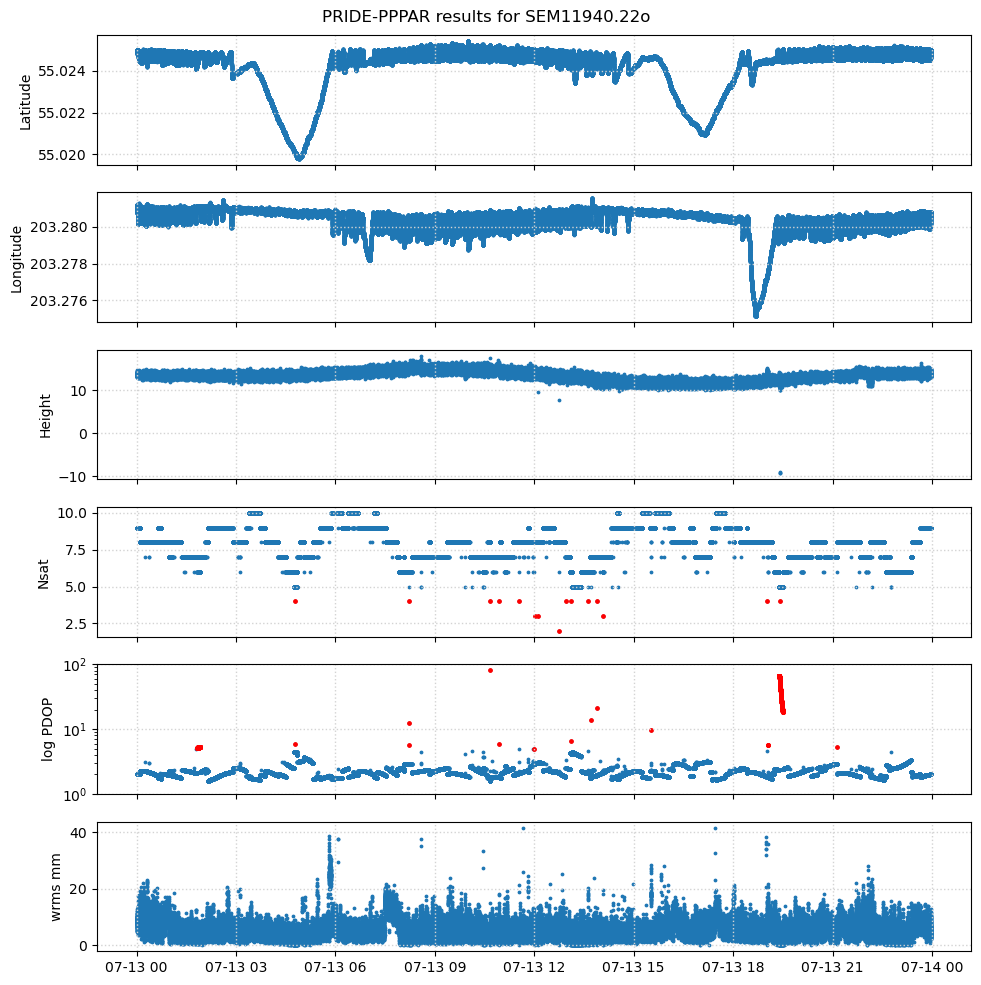

In [8]:
#plot kin results
size=3
bad_nsat = kin_df[kin_df['Nsat']<=4]
bad_pdop = kin_df[kin_df['PDOP']>=5]
bad_wrms = kin_df[kin_df['wrms']>=20]
fig, axs = plt.subplots(6,1, figsize=(10,10), sharex=True, )
axs[0].scatter(kin_df.index,kin_df['Latitude'],s=size)
axs[0].set_ylabel('Latitude')
axs[1].scatter(kin_df.index,kin_df['Longitude'],s=size)
axs[1].set_ylabel('Longitude')
axs[2].scatter(kin_df.index,kin_df['Height'],s=size)
axs[2].set_ylabel('Height')
axs[3].scatter(kin_df.index,kin_df['Nsat'],s=size)
axs[3].scatter(bad_nsat.index,bad_nsat['Nsat'],s=size*2, color='red')
axs[3].set_ylabel('Nsat')
axs[4].scatter(kin_df.index,kin_df['PDOP'],s=size)
axs[4].scatter(bad_pdop.index,bad_pdop['PDOP'],s=size*2, color='red')
axs[4].set_ylabel('log PDOP')
axs[4].set_yscale('log')
axs[4].set_ylim(1,100)
axs[5].scatter(kin_df.index,kin_df['wrms'],s=size)
#axs[5].scatter(bad_wrms.index,bad_wrms['wrms'],s=size*2, color='red')
axs[5].set_ylabel('wrms mm')
#axs[5].set_yscale('log')
#axs[5].set_ylim(0,100)

axs[0].ticklabel_format(axis='y',useOffset=False, style='plain')
axs[1].ticklabel_format(axis='y',useOffset=False, style='plain')
for ax in axs:
    ax.grid(True,c='lightgrey',zorder=0,lw=1,ls=':')
fig.suptitle(f"PRIDE-PPPAR results for {os.path.basename(rinex_path)}")
fig.tight_layout()
print(f"epochs with nsat <= 4: {round(len(bad_nsat)/len(kin_df)*100,2)} %")
print(f"epochs with PDOP >= 5: {round(len(bad_pdop)/len(kin_df)*100,2)} %")
print(f"epochs with wrms >= 20: {round(len(bad_wrms)/len(kin_df)*100,2)} %")


In [10]:
#parse the res file to make a plot of residuals vs elevation per sat
with open(res_path, "r") as res_file:
    timestamps = []
    data = []
    line = res_file.readline() #first line we can throw away
    while True: 
        if line == "":
            break
        line_data = line.split()
        if line_data[0] == 'TIM':
            seconds = float(line_data[6])
            SS = int(seconds)
            f = str(seconds - SS).split('.')[-1]
            isodate = f"{line_data[1]}-{line_data[2].zfill(2)}-{line_data[3].zfill(2)}T{line_data[4].zfill(2)}:{line_data[5].zfill(2)}:{str(SS).zfill(2)}.{f}"
            timestamp = datetime.fromisoformat(isodate)
            #timestamps.append(timestamp)
            #read data for that epoch
            line = res_file.readline()
            line_data = line.split()
            while not line.startswith('TIM'):
                #print(line_data)
                prn = line_data[0]
                line_data[3] = float(line_data[3].replace('D','E'))
                line_data[4] = float(line_data[4].replace('D','E'))
                row = [timestamp]+line_data
                data.append(row)
                line = res_file.readline()
                if line == "":
                    break
                line_data = line.split()
        else:
            line = res_file.readline()
#data
#res_df = pd.DataFrame({'date':timestamps,'wrms':data}).set_index('date')
#res_df

In [11]:
full_res_df = pd.DataFrame(data, columns=['date','prn','phase_res','psuedorange_res','phase_weight','psuedorange_weight',
                                          'data_status_id','elevation','azimuth','obs1','obs2','obs3','obs4'])
full_res_df=full_res_df.set_index(['date'])#,'prn'])
full_res_df

,prn,phase_res,psuedorange_res,phase_weight,psuedorange_weight,data_status_id,elevation,azimuth,obs1,obs2,obs3,obs4
date,,,,,,,,,,,,
2022-07-13 00:00:00,G01,-0.0011,-2.3259,129381.120,5.205675,1,28.947,-75.944,L1,L2,C1,P2
2022-07-13 00:00:00,G08,-0.0102,-1.7677,138076.990,5.555556,1,60.783,-134.020,L1,L2,C1,P2
2022-07-13 00:00:00,G10,-0.0079,-1.6878,138076.990,5.555556,1,49.071,65.911,L1,L2,C1,P2
2022-07-13 00:00:00,G14,-0.0013,-2.5374,48889.224,1.967068,1,17.309,-39.623,L1,L2,C1,P2
2022-07-13 00:00:00,G21,0.0118,-2.1024,138076.990,5.555556,1,59.633,-76.628,L1,L2,C1,P2
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-13 23:59:00,G22,0.0013,1.4470,134068.670,5.394280,0,29.517,147.493,L1,L2,C1,P2
2022-07-13 23:59:00,G23,0.0086,1.9155,44046.859,1.772234,0,16.404,60.801,L1,L2,C1,P2
2022-07-13 23:59:00,G27,0.0024,2.6354,138076.990,5.555556,0,33.766,173.262,L1,L2,C1,P2


In [15]:
satellites = []
with open(res_path, "r") as res_file:
    for i, line in enumerate(res_file):
        if "SATELLITE LIST" in line:
            line_data = line.split()
            satellites += line_data[:-2]
        if "END OF HEADER" in line:
            end_of_header = i
            break
#satellites

In [36]:
df = full_res_df[['prn','phase_res','elevation']].astype({'phase_res':'float','elevation':'float'})
#tmp_df = df[df['prn']=='G01'].sort_values('elevation')
#tmp_df = tmp_df

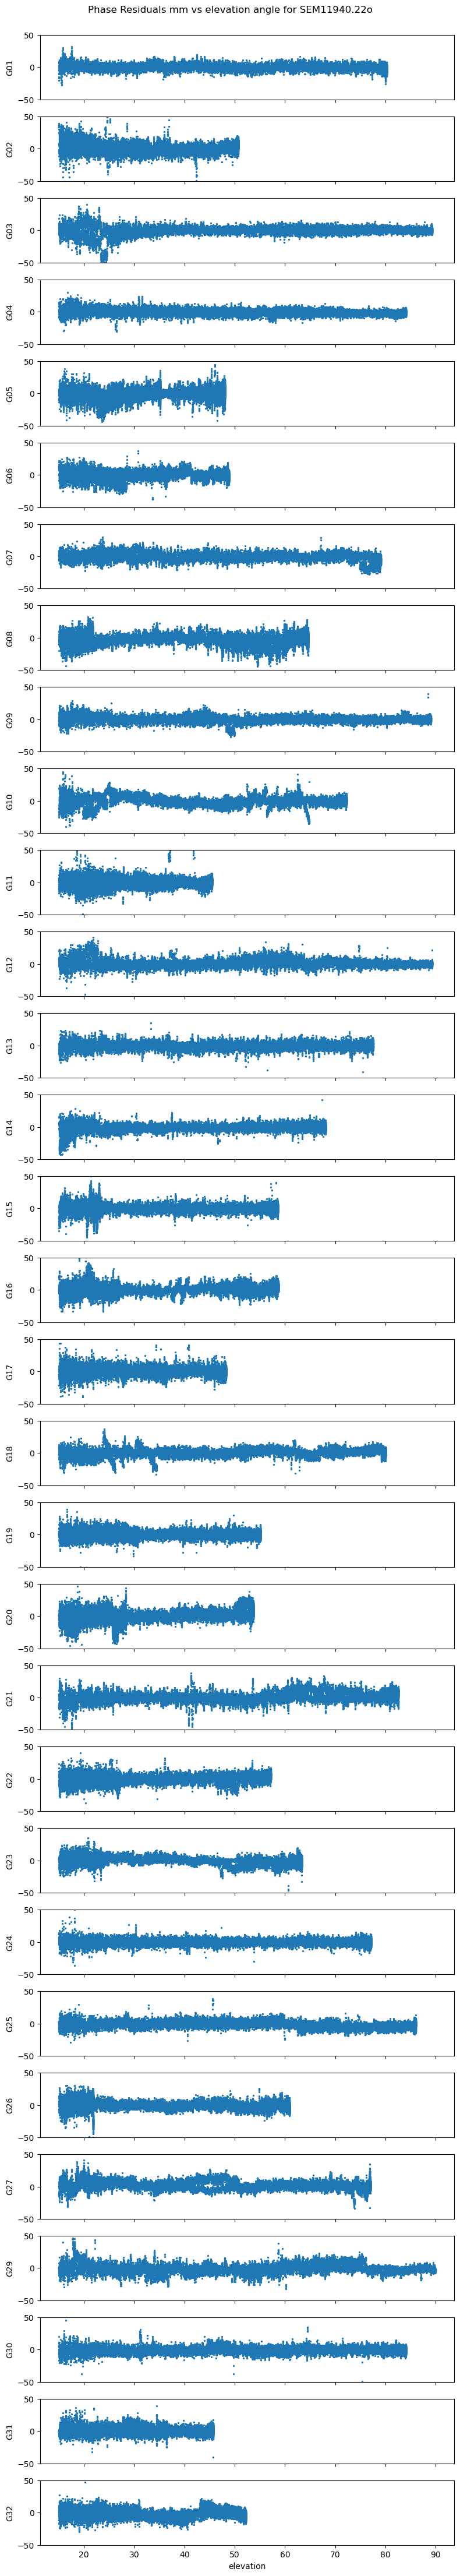

In [54]:

fig, axs = plt.subplots(len(satellites),1, figsize=(8,len(satellites)*1.5), sharex=True)
for i, prn in enumerate(satellites):
    tmp_df = df[df['prn']==prn]
    axs[i].scatter(tmp_df['elevation'],tmp_df['phase_res']*1000, s=2)
    axs[i].set_ylabel(prn)
    axs[i].set_ylim(-50,50)
axs[i].set_xlabel('elevation')
fig.suptitle(f"Phase Residuals mm vs elevation angle for {os.path.basename(rinex_path)}")
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    


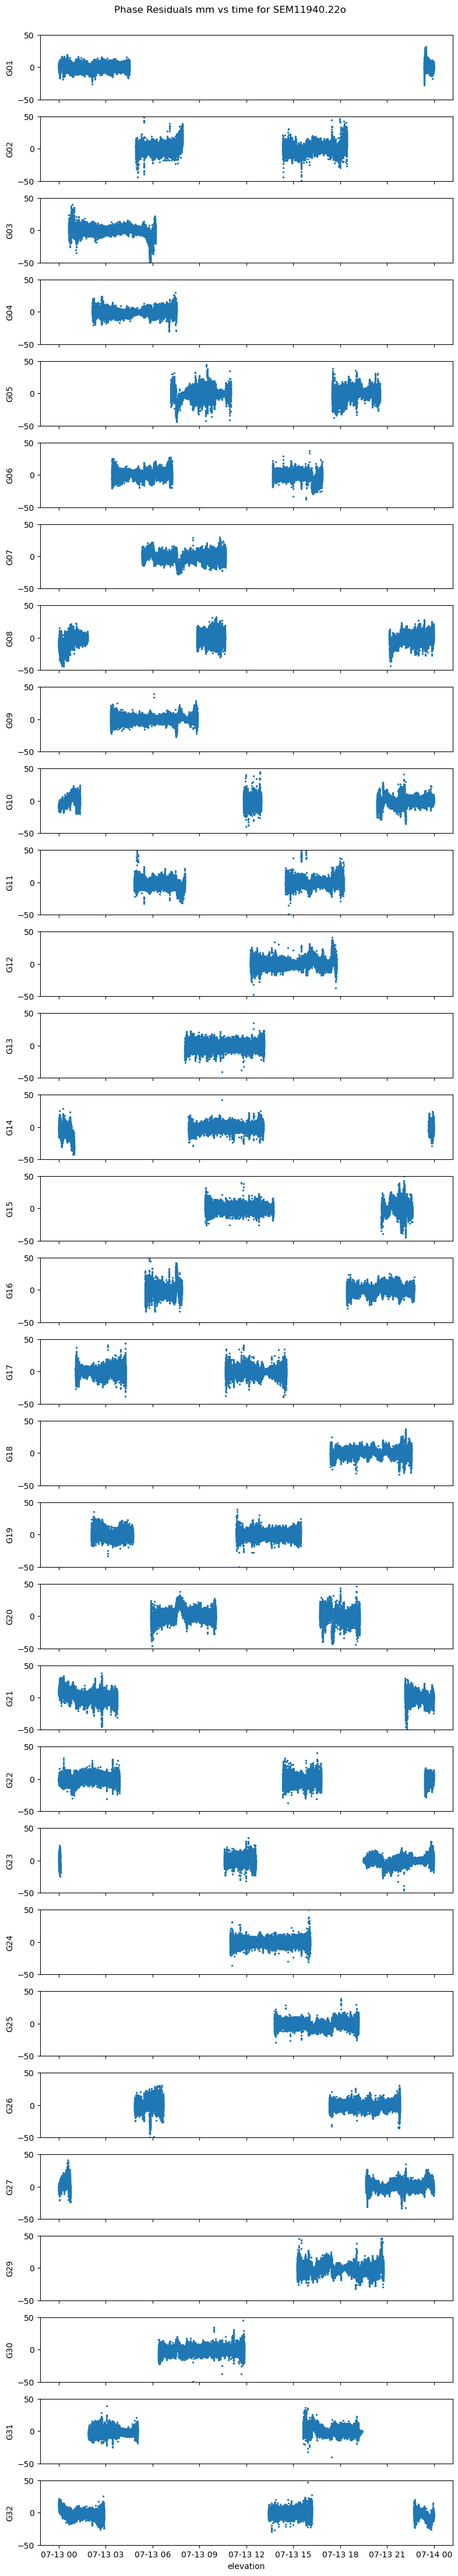

In [52]:

fig, axs = plt.subplots(len(satellites),1, figsize=(8,len(satellites)*1.5), sharex=True)
for i, prn in enumerate(satellites):
    tmp_df = df[df['prn']==prn]
    axs[i].scatter(tmp_df.index,tmp_df['phase_res']*1000, s=2)
    axs[i].set_ylabel(prn)
    axs[i].set_ylim(-50,50)
axs[i].set_xlabel('elevation')
fig.suptitle(f"Phase Residuals mm vs time for {os.path.basename(rinex_path)}")
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

# Parse the STT file for phase residuals

In [260]:
#read the stt file
stt_path = os.path.join(pride_dir, f"{year}/{dayOfYear}/stt_{year}{dayOfYear}_{site}")
#stt_path = os.path.join(data_handler.pride_dir, "2022/195/stt_2022195_be52")
with open(stt_path, "r") as stt_file:
        for line in stt_file:
            if "+TIME SERIES OF RESIDUALS---PHASE(MM)" in line:
                next_line = next(stt_file)
                #print(len(next_line))
                sats = next_line.split()[1:]
                num_sats = len(sats)
                #print(num_sats)


In [261]:
colspecs = [(0,6)]
for i in range(6,(num_sats+1)*4, 4):
    colspecs.append((i, i+4))
stt_df = pd.read_fwf(stt_path, header=6, colspecs=colspecs, index_col=0, on_bad_lines='skip', skipfooter=2)
stt_df

,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,...,G22,G23,G24,G25,G26,G27,G29,G30,G31,G32
sem1,,,,,,,,,,,,,,,,,,,,,
1,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0.0,...,0.0,1.0,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,1.0
2,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,-9.0,...,-1.0,12.0,NaN,NaN,NaN,-5.0,NaN,NaN,NaN,4.0
3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,-1.0,...,0.0,10.0,NaN,NaN,NaN,-4.0,NaN,NaN,NaN,-2.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,-6.0,...,-3.0,11.0,NaN,NaN,NaN,-5.0,NaN,NaN,NaN,4.0
5,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,-8.0,...,-1.0,12.0,NaN,NaN,NaN,-9.0,NaN,NaN,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86337,5.0,NaN,NaN,NaN,NaN,NaN,NaN,-6.0,NaN,0.0,...,3.0,-5.0,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,4.0
86338,6.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,-1.0,...,7.0,-1.0,NaN,NaN,NaN,-9.0,NaN,NaN,NaN,2.0
86339,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2.0,...,4.0,6.0,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,-6.0


In [262]:
#calculate unweighted RMS
stt_df2 = stt_df**2
stt_df['rms'] = stt_df2.sum(axis=1)**0.5
stt_df


,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,...,G23,G24,G25,G26,G27,G29,G30,G31,G32,rms
sem1,,,,,,,,,,,,,,,,,,,,,
1,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0.0,...,1.0,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,1.0,8.000000
2,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,-9.0,...,12.0,NaN,NaN,NaN,-5.0,NaN,NaN,NaN,4.0,23.173260
3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,-1.0,...,10.0,NaN,NaN,NaN,-4.0,NaN,NaN,NaN,-2.0,18.303005
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,-6.0,...,11.0,NaN,NaN,NaN,-5.0,NaN,NaN,NaN,4.0,20.024984
5,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,-8.0,...,12.0,NaN,NaN,NaN,-9.0,NaN,NaN,NaN,7.0,25.573424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86337,5.0,NaN,NaN,NaN,NaN,NaN,NaN,-6.0,NaN,0.0,...,-5.0,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,4.0,12.649111
86338,6.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,-1.0,...,-1.0,NaN,NaN,NaN,-9.0,NaN,NaN,NaN,2.0,16.522712
86339,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2.0,...,6.0,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,-6.0,13.114877


<Axes: title={'center': 'RMS of residuals'}, xlabel='sec of day', ylabel='mm'>

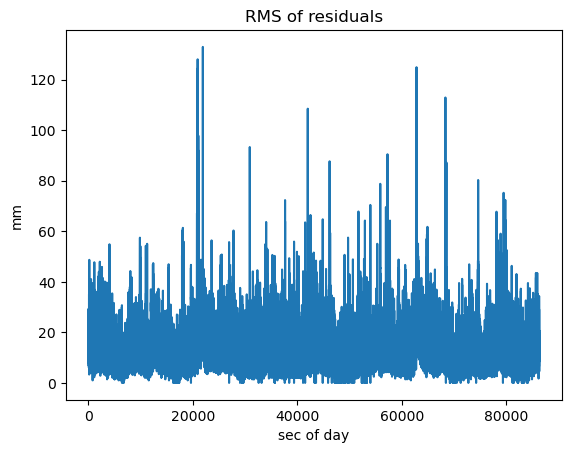

In [263]:
stt_df['rms'].plot(ylabel="mm", xlabel="sec of day",title='RMS of residuals')

<Axes: xlabel='sem1'>

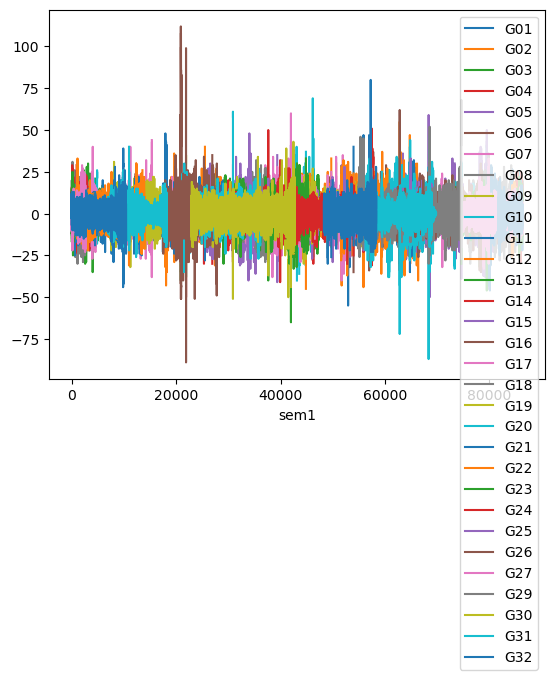

In [14]:
stt_df.plot()

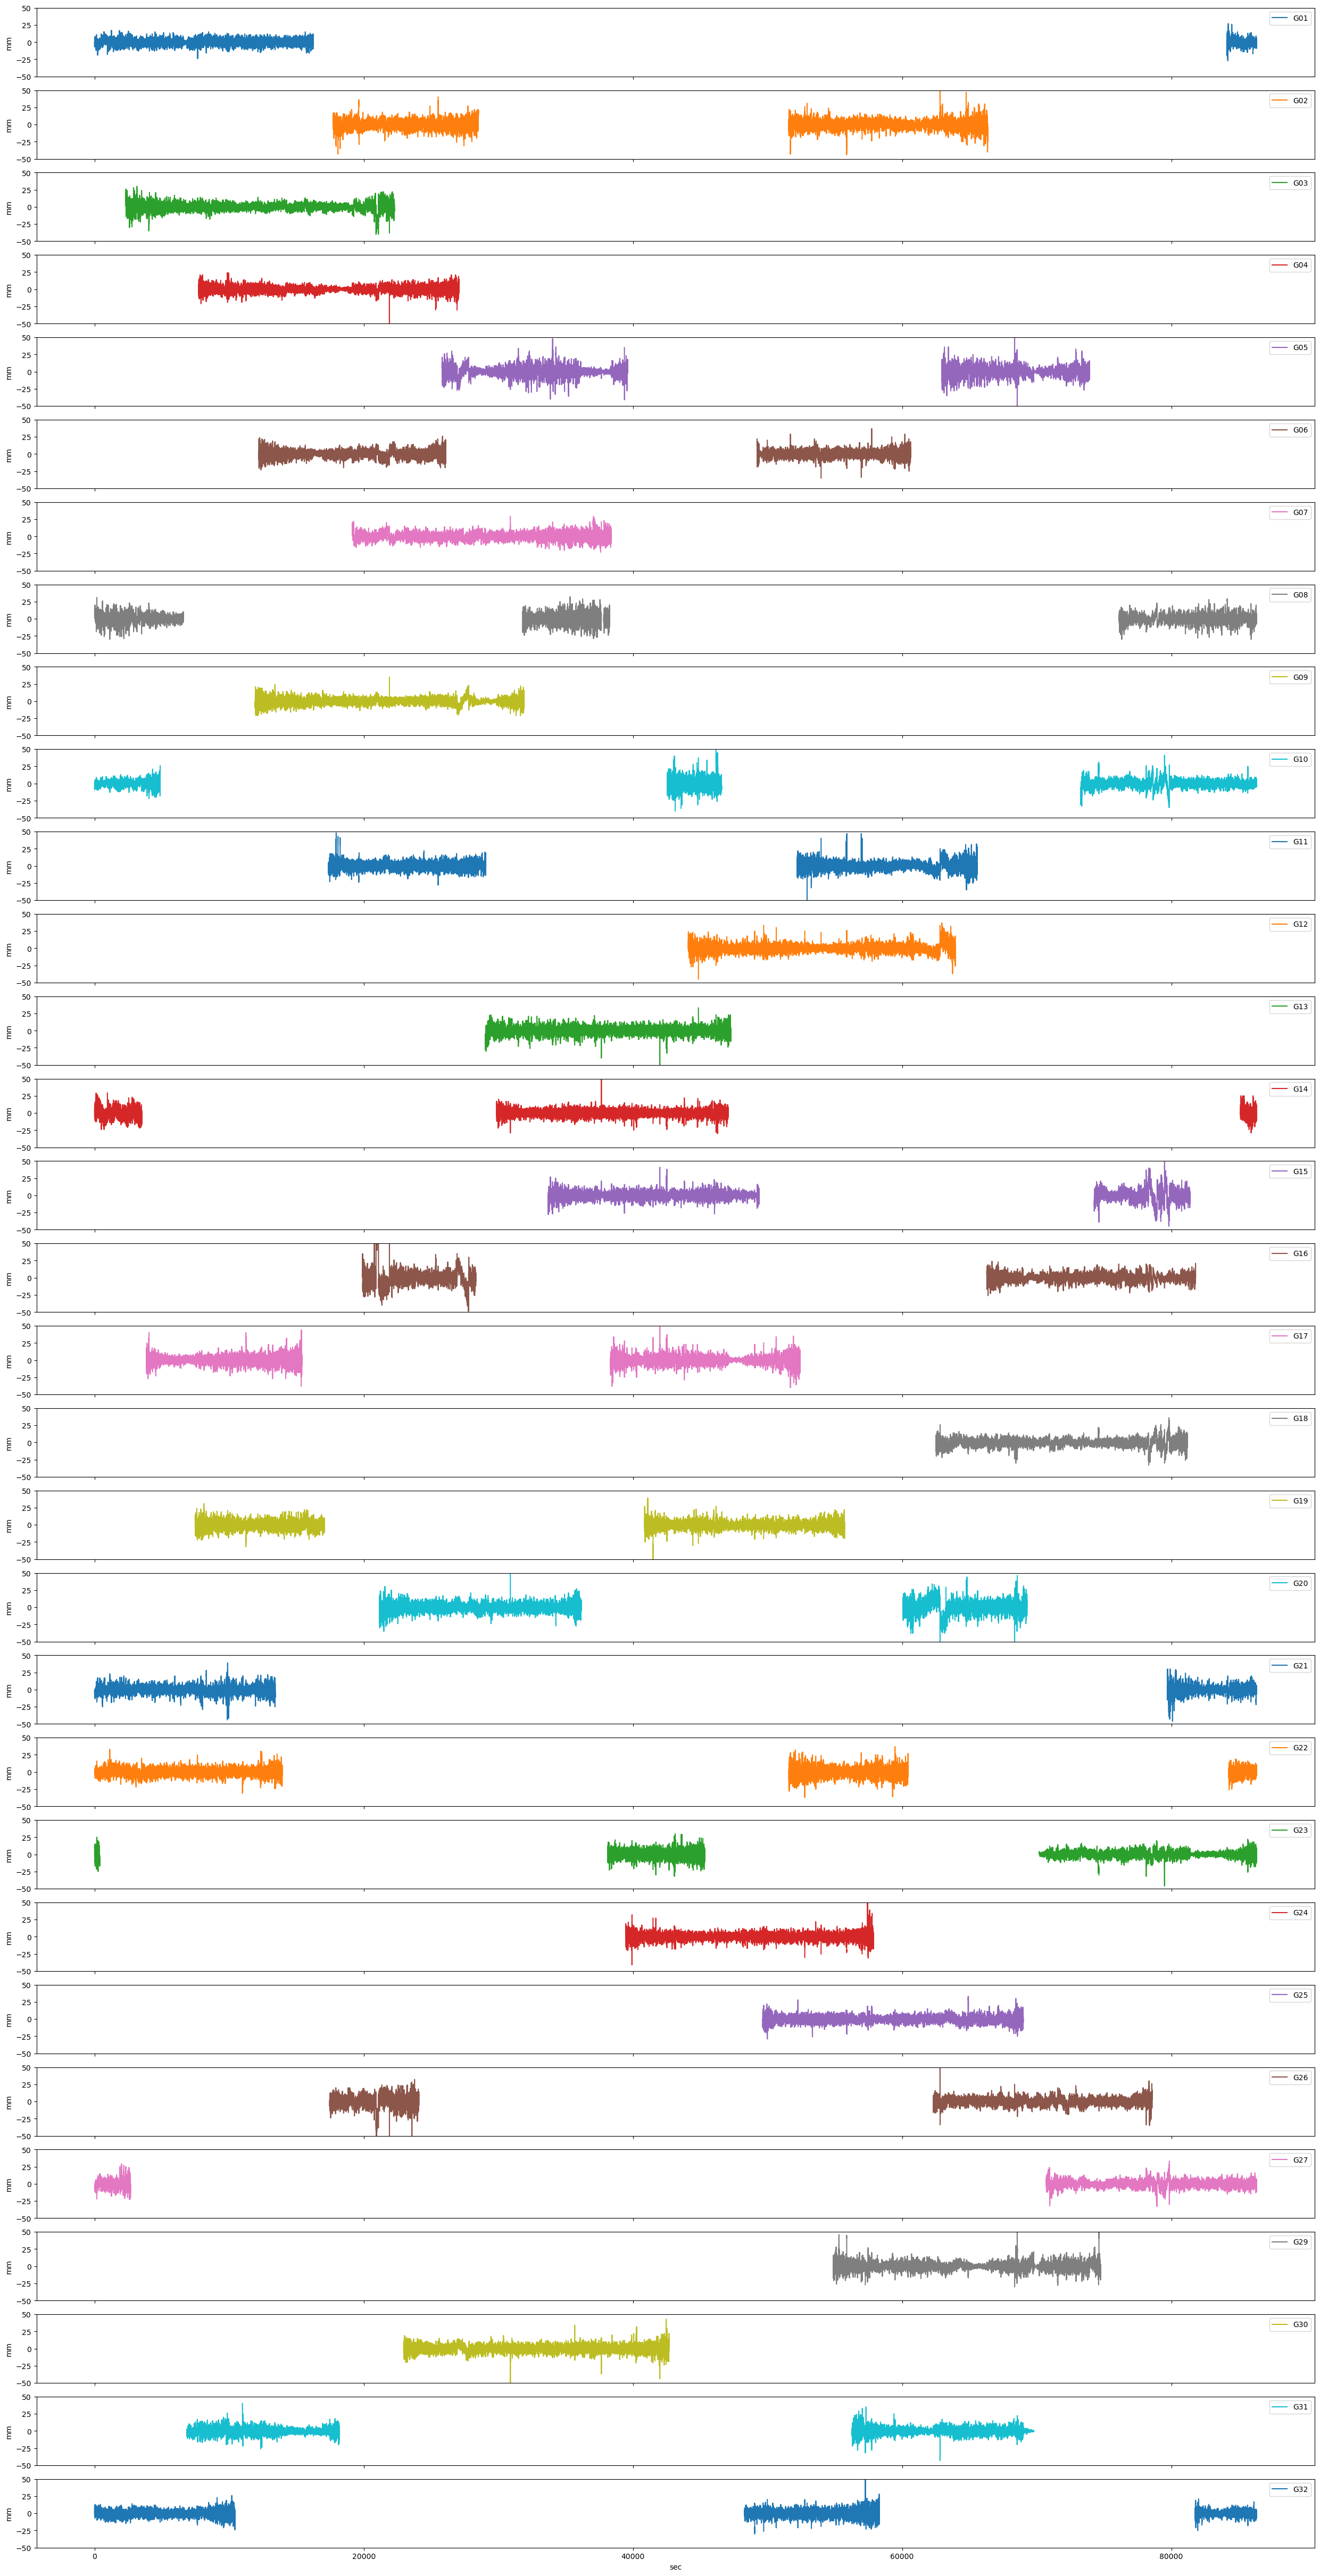

In [17]:
res = stt_df.plot(subplots=True, figsize=(num_sats,2*num_sats), ylabel="mm", xlabel="sec", ylim=[-50,50])